In [5]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

from utils_hf import *

savedir = "models/geodesic"
os.makedirs(savedir, exist_ok=True)

In [2]:
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

5000: loss 0.169 time 69.20


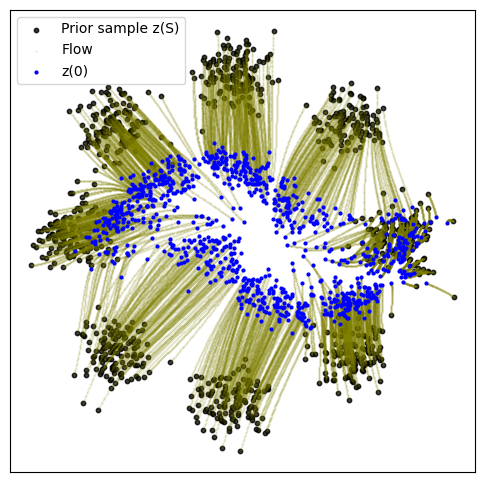

10000: loss 0.148 time 70.12


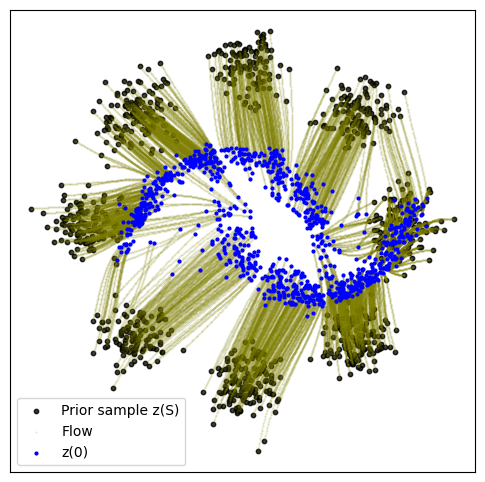

15000: loss 0.158 time 69.77


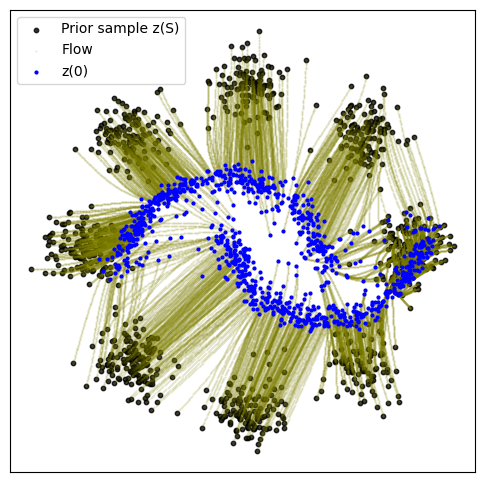

20000: loss 0.154 time 69.67


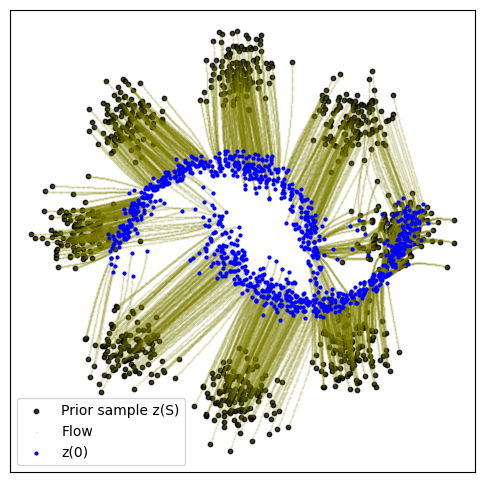

CPU times: user 4min 39s, sys: 432 ms, total: 4min 39s
Wall time: 4min 39s


In [3]:
%%time

FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
torch.save(model, f"{savedir}/otcfm_v1.pt")

In [6]:

num_samples = 1000
xx0 = sample_8gaussians(num_samples)
gif_quiver(model,savedir,xx0,num_samples,N = 50)